###### Import all our packges that we will be using acroos the project

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.init as init
import matplotlib.pyplot as plt

In [2]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=Compose([ToTensor()]),
    download=True,
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=Compose([ToTensor()]),
    download=True)

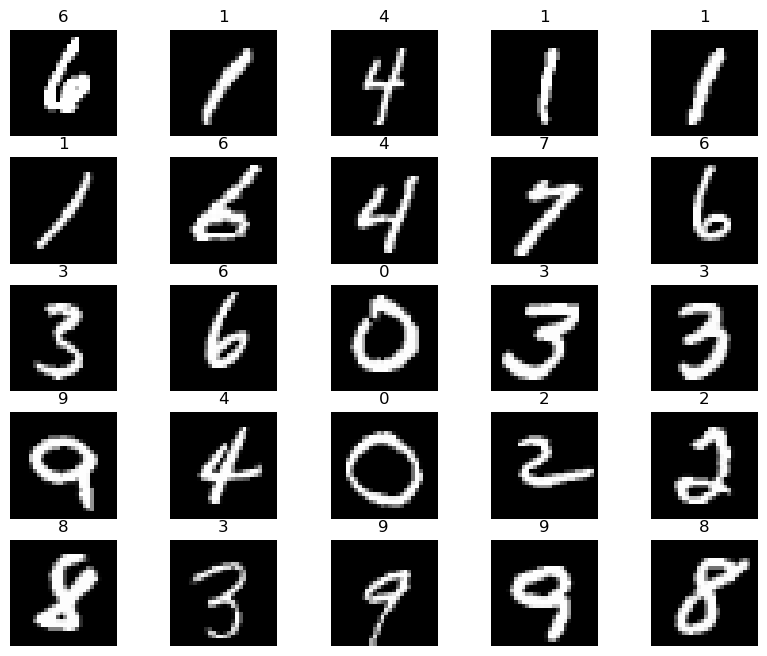

In [3]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

If a CUDA-enabled GPU is available, it will assign the device as `cuda`, and if not, it will assign the device as `cpu`.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


We define our neural network by subclassing ```nn.Module```, and initialize the neural network layers in ```__init__```. Every ```nn.Module``` subclass implements the operations on input data in the ```forward``` method.

In [6]:
# Architecture 1 (A1) - Set 1
class CNN_A1(nn.Module):
    def __init__(self):
        super(CNN_A1, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)  # 1 input channel, 4 output channels
        self.relu = nn.ReLU()
        self.fc = nn.Linear(4 * 26 * 26, 10)  # 4 * 26 * 26 is the output size of the convolutional layer, 10 - output this labels(classes of out DataSet - numbers from 0-9)
        self.relu1 = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) #SoftMax function
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu1(x)
        x = self.softmax(x)
        return x


In [7]:
# Architecture 2 (A2) - Set 2
class CNN_A2(nn.Module):
    def __init__(self, num_kernels):
        super(CNN_A2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)  # 1 input channel, 4 output channels
        self.conv2 = nn.Conv2d(4, num_kernels, kernel_size=3)  # 4 input channels, variable number of output channels
        self.fc = nn.Linear(num_kernels * 24 * 24, 10)  # num_kernels * 24 * 24 is the output size of the last convolutional layer
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [8]:
def plot_training_progress(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    # Plotting losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout() # Adjust the padding between and around subplots.
    plt.show()

In [9]:
def generate_weights_default(model):
    weights = []
    biases = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            weight = nn.init.normal_(module.weight.data.clone())
            bias = nn.init.constant_(module.bias.data.clone(), 0)
            weights.append(weight)
            biases.append(bias)
    return weights, biases

In [10]:
def initialize_weights_hf(model):
    device = next(model.parameters()).device
    with torch.no_grad():
        weights = torch.FloatTensor([[
          [1, 0, 0], [0, 1, 0], [0, 0, 1]],
          [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
          [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
          [[0, 0, 0], [1, 1, 1], [0, 0, 0]]]).to(device)
    
    weights = weights.view(4, 1, 3, 3)
    model.conv1.weight = nn.Parameter(weights, requires_grad=False)

In [11]:
def initialize_weights_ht(model, weights, biases):
    device = next(model.parameters()).device
    # Initialize first layer with by-Hand strategy
    with torch.no_grad():
        hand_weights = torch.FloatTensor([
            [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
            [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
            [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
            [[0, 0, 0], [1, 1, 1], [0, 0, 0]]
        ]).to(device)
        hand_weights = hand_weights.view(4, 1, 3, 3)
        model.conv1.weight = nn.Parameter(hand_weights, requires_grad=True)

    # Initialize remaining layers with the generated weights and biases
    index = 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if module is not model.conv1:
                module.weight.data.copy_(weights[index].to(device))
                module.bias.data.copy_(biases[index].to(device))
                index += 1

In [12]:
def initialize_weights_dt(model, weights, biases):
    index = 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            module.weight.data.copy_(weights[index])
            module.bias.data.copy_(biases[index])
            index += 1

## Trainig Part

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
def train_cnn(model, loss_fn, optimizer, train_loader, num_epochs):
    device = next(model.parameters()).device  # Get the device of the model's parameters
    
    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images = images.to(device)  # Move input tensor to the same device as the model
            labels = labels.to(device)  # Move label tensor to the same device as the model

            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions

        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return losses, accuracies

In [15]:
num_epochs = 20
learning_rate = 0.001
batch_size = 32

In [16]:
cnn1 = CNN_A1()
cnn1 = cnn1.to(device)
initialize_weights_hf(cnn1) # Initialize with HF schema

In [17]:
weights_default, biases_default = generate_weights_default(cnn1) # just helper to generate 

In [18]:
cnn2 = CNN_A1()
cnn2 = cnn2.to(device)
initialize_weights_ht(cnn2,weights_default[1:], biases_default[1:]) # Initialize with HT schema

In [19]:
cnn3 = CNN_A1()
cnn3 = cnn3.to(device)
initialize_weights_ht(cnn3,weights_default[1:], biases_default[1:])# Initialize with DT schema

In [20]:
weights_before_train_1 = cnn1.conv1.weight
weights_before_train_1

Parameter containing:
tensor([[[[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]],


        [[[0., 0., 1.],
          [0., 1., 0.],
          [1., 0., 0.]]],


        [[[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]],


        [[[0., 0., 0.],
          [1., 1., 1.],
          [0., 0., 0.]]]], device='cuda:0')

In [21]:
weights_before_train_2 = cnn2.conv1.weight
weights_before_train_2

Parameter containing:
tensor([[[[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]],


        [[[0., 0., 1.],
          [0., 1., 0.],
          [1., 0., 0.]]],


        [[[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]],


        [[[0., 0., 0.],
          [1., 1., 1.],
          [0., 0., 0.]]]], device='cuda:0', requires_grad=True)

In [22]:
weights_before_train_3 = cnn3.conv1.weight
weights_before_train_3

Parameter containing:
tensor([[[[1., 0., 0.],
          [0., 1., 0.],
          [0., 0., 1.]]],


        [[[0., 0., 1.],
          [0., 1., 0.],
          [1., 0., 0.]]],


        [[[0., 1., 0.],
          [0., 1., 0.],
          [0., 1., 0.]]],


        [[[0., 0., 0.],
          [1., 1., 1.],
          [0., 0., 0.]]]], device='cuda:0', requires_grad=True)

In [23]:
optimizer1 = torch.optim.SGD(cnn1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(cnn2.parameters(), lr=learning_rate)
optimizer3 = torch.optim.SGD(cnn3.parameters(), lr=learning_rate)

In [24]:
losses1, accuracies1 = train_cnn(cnn1, loss_fn, optimizer1, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.1648, Accuracy: 0.3189
Epoch 2/20, Loss: 2.0149, Accuracy: 0.4823
Epoch 3/20, Loss: 1.9438, Accuracy: 0.5497
Epoch 4/20, Loss: 1.9257, Accuracy: 0.5564
Epoch 5/20, Loss: 1.9172, Accuracy: 0.5601
Epoch 6/20, Loss: 1.9119, Accuracy: 0.5622
Epoch 7/20, Loss: 1.9082, Accuracy: 0.5637
Epoch 8/20, Loss: 1.9054, Accuracy: 0.5651
Epoch 9/20, Loss: 1.9033, Accuracy: 0.5659
Epoch 10/20, Loss: 1.9015, Accuracy: 0.5668
Epoch 11/20, Loss: 1.9001, Accuracy: 0.5674
Epoch 12/20, Loss: 1.8988, Accuracy: 0.5681
Epoch 13/20, Loss: 1.8977, Accuracy: 0.5687
Epoch 14/20, Loss: 1.8968, Accuracy: 0.5692
Epoch 15/20, Loss: 1.8959, Accuracy: 0.5696
Epoch 16/20, Loss: 1.8952, Accuracy: 0.5700
Epoch 17/20, Loss: 1.8945, Accuracy: 0.5704
Epoch 18/20, Loss: 1.8939, Accuracy: 0.5707
Epoch 19/20, Loss: 1.8933, Accuracy: 0.5713
Epoch 20/20, Loss: 1.8928, Accuracy: 0.5716


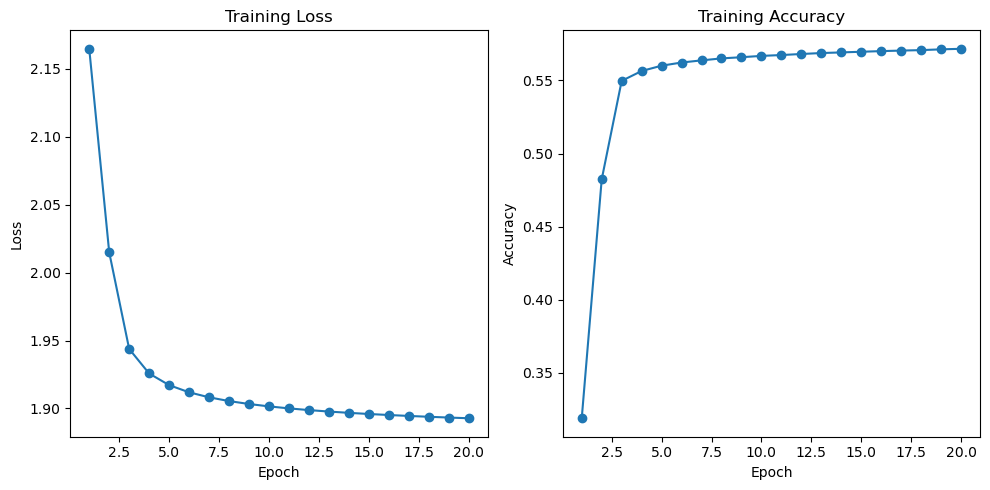

In [25]:
plot_training_progress(losses1, accuracies1)

In [26]:
losses2, accuracies2 = train_cnn(cnn2, loss_fn, optimizer2, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.4076, Accuracy: 0.0509
Epoch 2/20, Loss: 2.4035, Accuracy: 0.0551
Epoch 3/20, Loss: 2.3993, Accuracy: 0.0592
Epoch 4/20, Loss: 2.3946, Accuracy: 0.0639
Epoch 5/20, Loss: 2.3889, Accuracy: 0.0699
Epoch 6/20, Loss: 2.3825, Accuracy: 0.0760
Epoch 7/20, Loss: 2.3763, Accuracy: 0.0821
Epoch 8/20, Loss: 2.3690, Accuracy: 0.0897
Epoch 9/20, Loss: 2.3607, Accuracy: 0.0983
Epoch 10/20, Loss: 2.3530, Accuracy: 0.1056
Epoch 11/20, Loss: 2.3469, Accuracy: 0.1118
Epoch 12/20, Loss: 2.3408, Accuracy: 0.1183
Epoch 13/20, Loss: 2.3348, Accuracy: 0.1244
Epoch 14/20, Loss: 2.3296, Accuracy: 0.1297
Epoch 15/20, Loss: 2.3246, Accuracy: 0.1341
Epoch 16/20, Loss: 2.3197, Accuracy: 0.1397
Epoch 17/20, Loss: 2.3157, Accuracy: 0.1438
Epoch 18/20, Loss: 2.3123, Accuracy: 0.1471
Epoch 19/20, Loss: 2.3089, Accuracy: 0.1506
Epoch 20/20, Loss: 2.3055, Accuracy: 0.1538


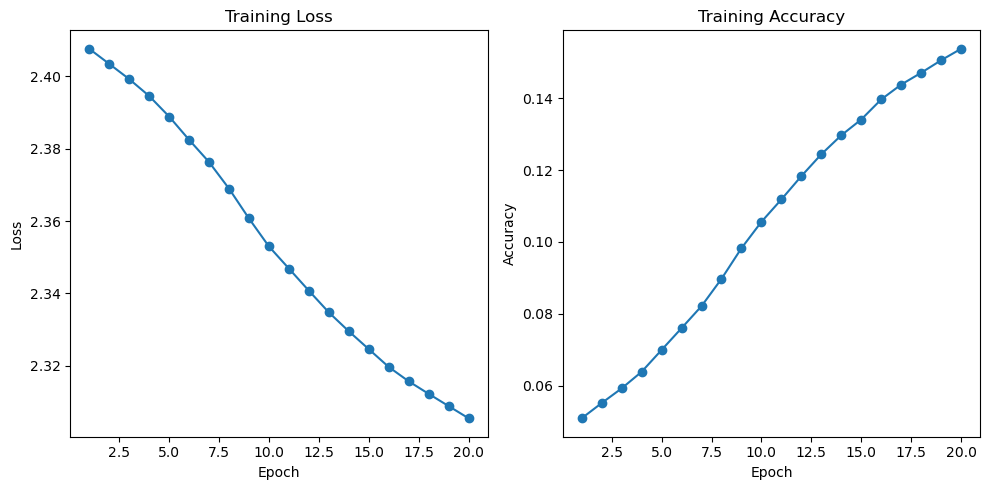

In [27]:
plot_training_progress(losses2, accuracies2)

In [28]:
losses3, accuracies3 = train_cnn(cnn3, loss_fn, optimizer3, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.4011, Accuracy: 0.0576
Epoch 2/20, Loss: 2.3962, Accuracy: 0.0624
Epoch 3/20, Loss: 2.3907, Accuracy: 0.0680
Epoch 4/20, Loss: 2.3849, Accuracy: 0.0739
Epoch 5/20, Loss: 2.3798, Accuracy: 0.0788
Epoch 6/20, Loss: 2.3742, Accuracy: 0.0848
Epoch 7/20, Loss: 2.3692, Accuracy: 0.0894
Epoch 8/20, Loss: 2.3643, Accuracy: 0.0947
Epoch 9/20, Loss: 2.3607, Accuracy: 0.0982
Epoch 10/20, Loss: 2.3580, Accuracy: 0.1010
Epoch 11/20, Loss: 2.3559, Accuracy: 0.1032
Epoch 12/20, Loss: 2.3539, Accuracy: 0.1052
Epoch 13/20, Loss: 2.3520, Accuracy: 0.1072
Epoch 14/20, Loss: 2.3501, Accuracy: 0.1093
Epoch 15/20, Loss: 2.3484, Accuracy: 0.1108
Epoch 16/20, Loss: 2.3471, Accuracy: 0.1120
Epoch 17/20, Loss: 2.3457, Accuracy: 0.1134
Epoch 18/20, Loss: 2.3443, Accuracy: 0.1150
Epoch 19/20, Loss: 2.3428, Accuracy: 0.1164
Epoch 20/20, Loss: 2.3414, Accuracy: 0.1180


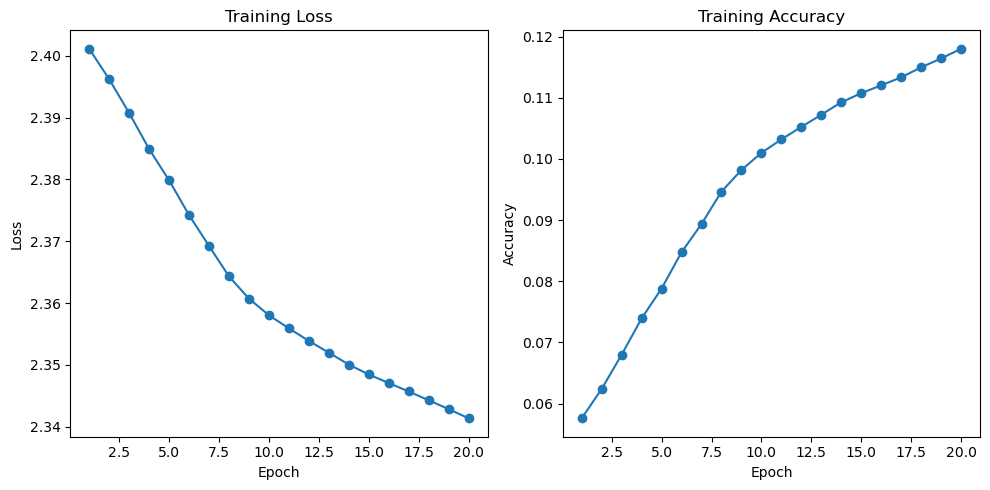

In [29]:
plot_training_progress(losses3, accuracies3)

In [30]:
cnn4 = CNN_A2(num_kernels=8)
cnn4 = cnn4.to(device)
initialize_weights_hf(cnn4)  # Initialize with HF schema

In [32]:
weights_default, biases_default = generate_weights_default(cnn4)

In [33]:
cnn5 = CNN_A2(num_kernels=8)
cnn5 = cnn5.to(device)
initialize_weights_ht(cnn5, weights_default[1:], biases_default[1:]) # Initialize with HT schema

In [34]:
cnn6 = CNN_A2(num_kernels=8)
cnn6 = cnn6.to(device)
initialize_weights_dt(cnn6, weights_default, biases_default)  # Initialize with DT schema

In [35]:
optimizer4 = torch.optim.SGD(cnn4.parameters(), lr=learning_rate)
optimizer5 = torch.optim.SGD(cnn5.parameters(), lr=learning_rate)
optimizer6 = torch.optim.SGD(cnn6.parameters(), lr=learning_rate)

In [36]:
losses4, accuracies4 = train_cnn(cnn4, loss_fn, optimizer4, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.0889, Accuracy: 0.4570
Epoch 2/20, Loss: 1.8165, Accuracy: 0.6830
Epoch 3/20, Loss: 1.7359, Accuracy: 0.7566
Epoch 4/20, Loss: 1.6769, Accuracy: 0.8116
Epoch 5/20, Loss: 1.6618, Accuracy: 0.8185
Epoch 6/20, Loss: 1.6541, Accuracy: 0.8219
Epoch 7/20, Loss: 1.6491, Accuracy: 0.8247
Epoch 8/20, Loss: 1.6455, Accuracy: 0.8267
Epoch 9/20, Loss: 1.6428, Accuracy: 0.8279
Epoch 10/20, Loss: 1.6406, Accuracy: 0.8293
Epoch 11/20, Loss: 1.6388, Accuracy: 0.8306
Epoch 12/20, Loss: 1.6373, Accuracy: 0.8316
Epoch 13/20, Loss: 1.6360, Accuracy: 0.8324
Epoch 14/20, Loss: 1.6348, Accuracy: 0.8334
Epoch 15/20, Loss: 1.6338, Accuracy: 0.8340
Epoch 16/20, Loss: 1.6328, Accuracy: 0.8346
Epoch 17/20, Loss: 1.6320, Accuracy: 0.8350
Epoch 18/20, Loss: 1.6312, Accuracy: 0.8358
Epoch 19/20, Loss: 1.6304, Accuracy: 0.8365
Epoch 20/20, Loss: 1.5726, Accuracy: 0.9001


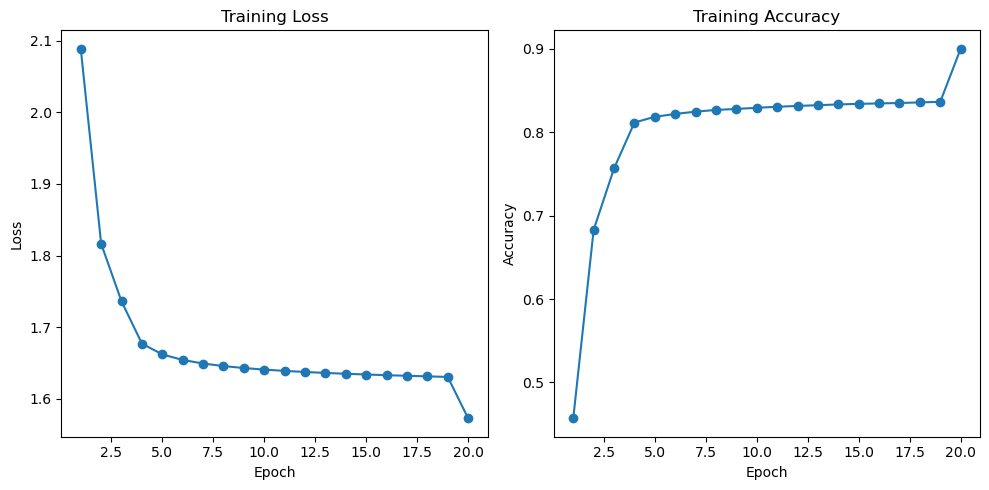

In [37]:
plot_training_progress(losses4, accuracies4)

In [42]:
losses5, accuracies5 = train_cnn(cnn5, loss_fn, optimizer5, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.2354, Accuracy: 0.2254
Epoch 2/20, Loss: 2.2303, Accuracy: 0.2304
Epoch 3/20, Loss: 2.2257, Accuracy: 0.2349
Epoch 4/20, Loss: 2.2208, Accuracy: 0.2400
Epoch 5/20, Loss: 2.2167, Accuracy: 0.2440
Epoch 6/20, Loss: 2.2128, Accuracy: 0.2479
Epoch 7/20, Loss: 2.2090, Accuracy: 0.2519
Epoch 8/20, Loss: 2.2054, Accuracy: 0.2552
Epoch 9/20, Loss: 2.2022, Accuracy: 0.2585
Epoch 10/20, Loss: 2.1994, Accuracy: 0.2613
Epoch 11/20, Loss: 2.1970, Accuracy: 0.2635
Epoch 12/20, Loss: 2.1944, Accuracy: 0.2664
Epoch 13/20, Loss: 2.1915, Accuracy: 0.2693
Epoch 14/20, Loss: 2.1887, Accuracy: 0.2721
Epoch 15/20, Loss: 2.1859, Accuracy: 0.2750
Epoch 16/20, Loss: 2.1835, Accuracy: 0.2773
Epoch 17/20, Loss: 2.1810, Accuracy: 0.2798
Epoch 18/20, Loss: 2.1784, Accuracy: 0.2824
Epoch 19/20, Loss: 2.1761, Accuracy: 0.2847
Epoch 20/20, Loss: 2.1737, Accuracy: 0.2871


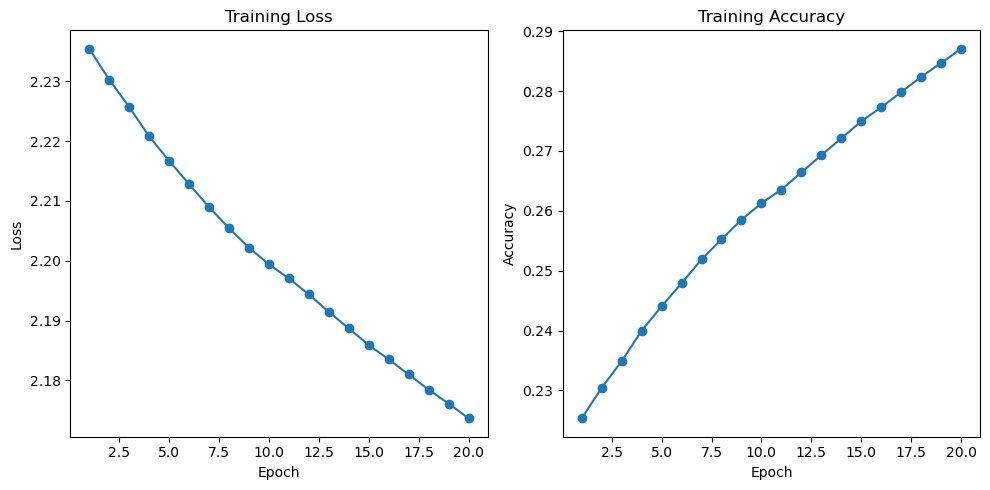

In [43]:
plot_training_progress(losses5, accuracies5)

In [44]:
losses6, accuracies6 = train_cnn(cnn6, loss_fn, optimizer5, train_dataloader, num_epochs)

Epoch 1/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 2/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 3/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 4/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 5/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 6/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 7/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 8/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 9/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 10/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 11/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 12/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 13/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 14/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 15/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 16/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 17/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 18/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 19/20, Loss: 2.3517, Accuracy: 0.1092
Epoch 20/20, Loss: 2.3517, Accuracy: 0.1092


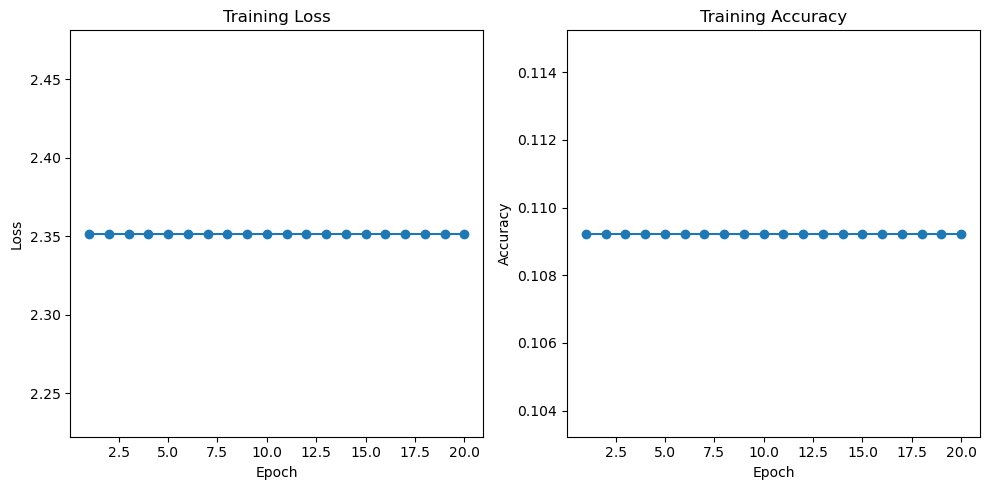

In [45]:
plot_training_progress(losses6, accuracies6)

## Testing DNN

In [48]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_samples = len(test_loader.dataset)
    correct_predictions = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move input tensor to the same device as the model
            labels = labels.to(device)  # Move labels tensor to the same device as the model

            # Forward pass
            outputs = model(images)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Count correct predictions
            correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = (correct_predictions / total_samples) * 100

    print(f"Test Accuracy: {accuracy:.2f}%")

In [49]:
test_model(cnn1, test_dataloader)

Test Accuracy: 57.39%


In [50]:
test_model(cnn2, test_dataloader)

Test Accuracy: 15.55%


In [51]:
test_model(cnn3, test_dataloader)

Test Accuracy: 12.28%


In [52]:
test_model(cnn4, test_dataloader)

Test Accuracy: 91.20%


In [53]:
test_model(cnn5, test_dataloader)

Test Accuracy: 28.64%


In [54]:
test_model(cnn6, test_dataloader)

Test Accuracy: 11.30%


## Experiment 1 - inset comparison

### Trainig A1
To compare the performance of CNN_A1 with different initialization schemas, we will analyze the results obtained for each schema: HF, HT, and DT.

    1. HF Schema
        a. After 20 epochs, the model achieved an accuracy of 57.16%.
        b. Loss decreased from 2.4076 to 1.8928 during training.
    2. HT Schema
        a. After 20 epochs, the model achieved an accuracy of 11.80%.
        b. Loss decreased from 2.4011 to 2.3414 during training.
    3. DT Schema
        a. After 20 epochs, the model achieved an accuracy of 15.38%.
        b. Loss decreased from 2.4011 to 2.3055 during training.

#### Observations:

   * The HF schema, where the first layer is initialized with the "by-Hand" strategy, the best results. It achieves the highest accuracy of 57.16% after 20 epochs.
   * The HT schema, where both the first and remaining layers are initialized with the "by-Hand" and default strategies, respectively, shows a lower accuracy of 11.80%.
   * The DT schema, where all layers are initialized with the default strategy, performs better than the HT schema but still has a lower accuracy of 15.38%.
   
#### Conclusion:
The choice of initialization schema significantly impacts the performance of CNN_A1. The HF schema, with the "by-Hand" initialization for the first layer, outperforms the other schemas in terms of accuracy. It allows the model to learn and converge faster, resulting in better overall performance. Therefore, for the CNN_A1 model, it is recommended to use the HF schema for better results.

#### Testing A1
  * Test Accuracy: 57.39% - CNN_A1 - HF Schema
  * Test Accuracy: 15.55% - CNN_A1 - HT Schema
  * Test Accuracy: 12.28% - CNN_A1 - DT Schema
  
  
### Trainig A2
To compare the performance of CNN_A2 with different initialization schemas, we will analyze the results obtained for each schema: HF, HT, and DT.

    1. HF Schema
        a. After 20 epochs, the model achieved an accuracy of 90.01%.
        b. Loss decreased from 2.0889 to 1.5726 during training.
    2. HT Schema
        a. After 20 epochs, the model achieved an accuracy of 11.80%.
        b. Loss decreased from 2.2354 to 2.1737 during training.
    3. DT Schema
        a. After 20 epochs, the model achieved an accuracy of 15.38%.
        b. Loss stabel 2.3517 during training.
        
#### Observations:

   * The HF schema shows significant improvement in accuracy compared to the other schemas. The accuracy starts at 45.70% and steadily increases to 90.01% by the 20th epoch. This indicates that initializing the first layer with a by-Hand strategy and training the subsequent layers leads to better performance.
   * The HT schema demonstrates limited improvement in accuracy compared to the DT schema. The accuracy starts at 22.54% and reaches 28.71% by the 20th epoch. Although the first layer is initialized with a by-Hand strategy, training all layers does not significantly enhance the performance.
   * The DT schema shows the lowest accuracy among the three schemas. The accuracy remains constant at 10.92% throughout all 20 epochs. Initializing all layers, including the first one, with the default strategy and training them does not lead to notable improvements.

#### Conclusion
Based on the results, the HF schema performs the best, followed by the HT schema, while the Default-Trained DT schema performs the worst. Initializing the first layer with a by-Hand strategy and training the subsequent layers seems to contribute to improved accuracy.

#### Testing A1
  * Test Accuracy: 91.20% - CNN_A1 - HF Schema
  * Test Accuracy: 28.64% - CNN_A1 - HT Schema
  * Test Accuracy: 11.30% - CNN_A1 - DT Schema
  
  
Overall, both sets A1 and A2 showed that initializing the first layer of the model with a HF schema resulted in the best performance. This highlights the importance of appropriate initialization techniques for neural network models.

## Experiment 2 – architecture comparison

### 1. CNN_A1(HF) -> CNN_A2(HF)

#### CNN_A1 - HF Schema:

    Epoch 1/20, Loss: 2.1648, Accuracy: 0.3189
    Epoch 20/20, Loss: 1.8928, Accuracy: 0.5716
    Test Accuracy: 57.39%

#### CNN_A2 - HF Schema:

    Epoch 1/20, Loss: 2.0889, Accuracy: 0.4570
    Epoch 20/20, Loss: 1.5726, Accuracy: 0.9001
    Test Accuracy: 91.20%
#### Observations:
* Both CNN_A1 and CNN_A2 start with different initial accuracies and losses in the first epoch.
* As training progresses, CNN_A1 shows gradual improvement in accuracy and reduction in loss, although the increase in accuracy is not as significant as in CNN_A2.
* In contrast, CNN_A2 demonstrates a remarkable improvement in accuracy, starting at 45.70% and reaching an impressive accuracy of 90.01% by the 20th epoch.

#### Conclusion:
* The direct comparison between CNN_A1 and CNN_A2 with the HF initialization schema clearly shows that CNN_A2 outperforms CNN_A1 in terms of both accuracy and loss.
* CNN_A2 achieves a higher accuracy of 91.20% compared to 57.39% achieved by CNN_A1.

### 2. CNN_A1(HT) -> CNN_A2(HT)

#### CNN_A1 - HT Schema:

    Epoch 1/20, Loss: 2.4076, Accuracy: 0.0509
    Epoch 20/20, Loss: 2.3055, Accuracy: 0.1538
    Test Accuracy: 15.55%

#### CNN_A2 - HT Schema:

    Epoch 1/20, Loss: 2.3517, Accuracy: 0.1092
    Epoch 20/20, Loss: 2.3517, Accuracy: 0.1092
     Test Accuracy: 28.64%
    
#### Observations:
* Both CNN_A1 and CNN_A2 with the HT initialization schema start with relatively low accuracies and high losses in the first epoch.
* As training progresses, both models show improvement in accuracy, but the increase is more significant in CNN_A2 compared to CNN_A1.
* CNN_A1 achieves a final accuracy of 15.55% after 20 epochs, while CNN_A2 achieves a higher accuracy of 28.64% within the same number of epochs.

#### Conclusion:
* The direct comparison between CNN_A1 and CNN_A2 with the HT initialization schema reveals that CNN_A2 performs better in terms of both accuracy and loss.
* CNN_A2 achieves a higher accuracy of 28.64% compared to 15.55% achieved by CNN_A1.

### 3. CNN_A1(DT) -> CNN_A2(DT)

#### CNN_A1 - DT Schema:

    Epoch 1/20, Loss: 2.4011, Accuracy: 0.0576
    Epoch 20/20, Loss: 2.3414, Accuracy: 0.1180
    Test Accuracy: 12.28%

#### CNN_A2 - HT Schema:

    Epoch 1/20, Loss: 2.2354, Accuracy: 0.2254
    Epoch 20/20, Loss: 2.1737, Accuracy: 0.2871
    Test Accuracy: 11.30%
   
    
#### Observations:
   *  Both CNN_A1 and CNN_A2 with the DT initialization schema start with low accuracies and high losses in the first epoch.
   * CNN_A1 shows a slight improvement in accuracy over the epochs but remains at a low accuracy of 12.28% after 20 epochs.
   * CNN_A2 on the other hand, exhibits the same accuracy of 11.3%toughout all 20 epochs, indicating a lack of learning or convergence.
   * Both models show minimal changes in loss values throughout training.

#### Conclusion:
* The comparison between CNN_A1 and CNN_A2 with the DT initialization schema reveals that neither model performs well in terms of accuracy.
* CNN_A1 achieves a slightly higher accuracy of 12.28% compared to the constant accuracy of 11.30% in CNN_A2.

## Experiment 3 - recovery comparison

### A2-HF to all the CNNs in the set A1
#### CNN_A2 - HF Schema:

    Epoch 1/20, Loss: 2.0889, Accuracy: 0.4570
    Epoch 20/20, Loss: 1.5726, Accuracy: 0.9001
    Test Accuracy: 91.20%

#### CNN_A1 - HF Schema:

    Epoch 1/20, Loss: 2.1523, Accuracy: 0.3348
    Epoch 20/20, Loss: 1.8762, Accuracy: 0.5992
    Test Accuracy: 59.95%

#### CNN_A1 - HT Schema:

    Epoch 1/20, Loss: 2.1523, Accuracy: 0.3348
    Epoch 20/20, Loss: 1.8762, Accuracy: 0.5992
    Test Accuracy: 59.95%

#### CNN_A1 - DT Schema:
    Epoch 1/20, Loss: 2.4011, Accuracy: 0.0576
    Epoch 20/20, Loss: 2.3414, Accuracy: 0.1180
    Test Accuracy: 11.92%

#### Observations:
* A2-HF achieves the highest test accuracy of 91.20% among all the models, indicating superior performance.
* CNN_A1 with HF schema achieves a test accuracy of 59.95%, while CNN_A1 with HT and DT schemas perform significantly lower with test accuracies of 15.55% and 11.92% respectively.
* It's evident that A2-HF outperforms all the CNN_A1 models in terms of both accuracy and loss.

#### Conclusion:
* A2-HF demonstrates superior performance compared to the CNN_A1 models in this experiment, achieving the highest test accuracy of 91.20% after 20 epochs.
* The HF initialization schema seems to contribute significantly to the improved performance of A2-HF compared to the CNN_A1 models.
* The choice of architecture and initialization schema has a substantial impact on the performance and learning capability of the CNN models. In this case, A2-HF performs the best, while CNN_A1 with HT and DT schemas show lower accuracy and slower convergence.